# Applied Machine Learning Mini Project

## Choice of model 
Add explanation for choice of model, 
because it is either yes or no and so on maybe make pros and cons of models.

## Objectives

1. Load and explore the dataset.
2. Preprocess the data, including handling missing values and scaling features.
3. Split the data into training and testing sets.
4. Train a logistic regression model.
5. Train a Random Forest Classifier
6. Evaluate the model using various metrics such as confusion matrix, classification report, ROC curve, and precision-recall curve.
7. Visualize the results to gain insights into the model's performance.

First the needed dependencies are loaded.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from imblearn.under_sampling import RandomUnderSampler

The dataset is loaded and checked for missing values, along with differences in the data. 

In [2]:
# Load the dataset
df = pd.read_csv('ai4i2020.csv')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Check the number of ones vs zeroes in the column 'Machine failure'
machine_failure_counts = df['Machine failure'].value_counts()
print("\nNumber of ones vs zeroes in 'Machine failure' column:\n", machine_failure_counts)

Missing values in each column:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Number of ones vs zeroes in 'Machine failure' column:
 Machine failure
0    9661
1     339
Name: count, dtype: int64


In [3]:
# Define the target variable and feature variables
X = df.drop(columns=['Machine failure', 'Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'UDI'])
y = df['Machine failure']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Random Under Sampler to the training set
#undersampler = RandomUnderSampler(random_state=42)
#X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Scale the feature variables
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Model Choice 
Different models where tried LogReg, 
## Random Forest
1. Different models where tested and random forest outperformed other especially Logistic Regression which may be because the data does not have a linear relation. 
2. Its ensemble approach helps prevent overfitting and makes it more resilient to noise, leading to improved generalization.

## Support Vector Machines (SVM)
1. SVMs are effective in datasets with non-linear relationships.
2. SVM can help address imbalanced datasets, improving performance on minority classes.


In [4]:
def grid_search_cv(X_train_scaled, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', None]
    }
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        scoring='f1'
    )
    
    
    # Precision: [ \text{Precision} = \frac{50}{50 + 5} = \frac{50}{55} \approx 0.91 ]
    # Recall: [ \text{Recall} = \frac{50}{50 + 10} = \frac{50}{60} \approx 0.83 ]
    # F1 Score: [ \text{F1 Score} = 2 \times \frac{0.91 \times 0.83}{0.91 + 0.83} \approx 0.87 ]
    
    start_time = time.time()
    grid_search.fit(X_train_scaled, y_train)
    duration = time.time() - start_time
    
    return grid_search.best_estimator_, (grid_search.best_params_, grid_search.best_score_, duration)

grid_result, returns = grid_search_cv(X_train, y_train)
print(returns)

({'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, 0.7279756481907695, 128.24705410003662)


Cross-validation scores: [0.70103093 0.68817204 0.8125     0.76470588 0.67346939]
Mean cross-validation score: 0.7279756481907695
Standard deviation of cross-validation scores: 0.05248762428884325
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.84      0.59      0.69        61

    accuracy                           0.98      2000
   macro avg       0.91      0.79      0.84      2000
weighted avg       0.98      0.98      0.98      2000



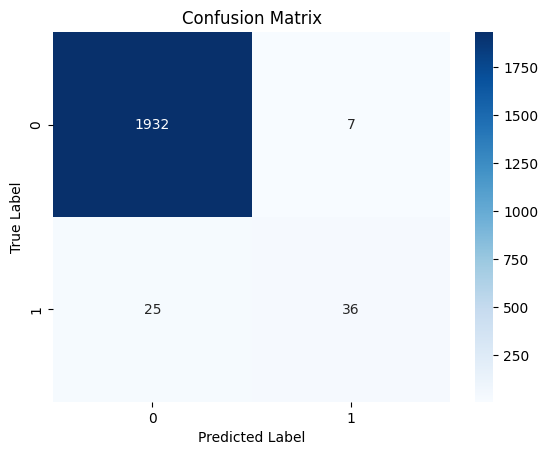

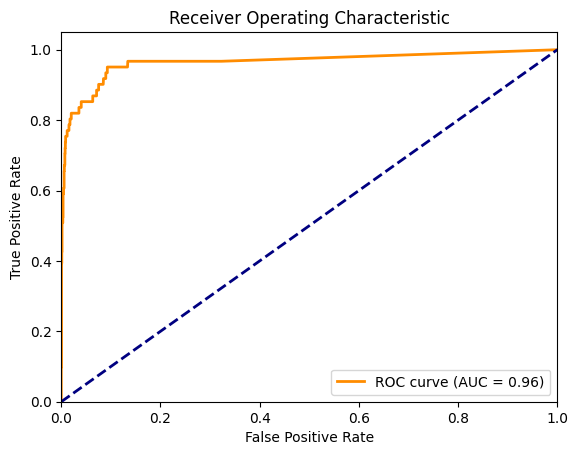

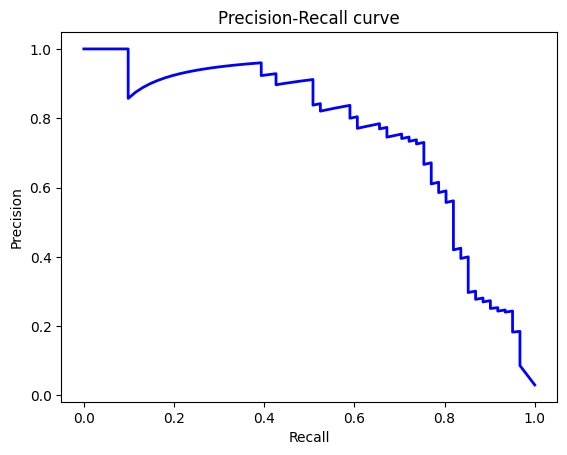

                   Feature  Importance
3              Torque [Nm]    0.330646
2   Rotational speed [rpm]    0.217423
4          Tool wear [min]    0.158923
0      Air temperature [K]    0.153972
1  Process temperature [K]    0.139036


In [5]:
# Perform cross-validation to check for outliers
# Stratification: Ensures that each fold has the same proportion of class labels as the original dataset. 
# K-Folds: The dataset is split into k equally sized folds. 
# Training and Validation: In each iteration, one fold is used for validation, and the remaining k-1 folds are used for training. 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(grid_result, X_train, y_train, cv=cv, scoring='f1')

print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())
print("Standard deviation of cross-validation scores:", cross_val_scores.std())

# Assuming y_test and y_pred are already defined
y_pred = grid_result.predict(X_test)
y_pred_proba = grid_result.predict_proba(X_test)[:, 1]

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()



# Assuming grid_result is the best Random Forest model from GridSearchCV
feature_importances = grid_result.feature_importances_
feature_names = X.columns  # Ensure feature names are taken from the correct DataFrame

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)


In [10]:
def grid_search_cv(X_train_scaled, y_train):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'class_weight': ['balanced', None]
    }
    
    svm = SVC(probability=True, random_state=42)
    grid_search = GridSearchCV(
        svm,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        scoring='f1'
    )
    
    start_time = time.time()
    grid_search.fit(X_train_scaled, y_train)
    duration = time.time() - start_time
    
    return grid_search.best_estimator_, (grid_search.best_params_, grid_search.best_score_, duration)


# Example usage
grid_result, returns = grid_search_cv(X_train, y_train)
print("Best parameters found: ", returns[0])
print("Best cross-validation score: ", returns[1])
print("Duration of grid search: ", returns[2])

Best parameters found:  {'C': 100, 'class_weight': None, 'kernel': 'linear'}
Best cross-validation score:  0.2923687735963951
Duration of grid search:  833.2888994216919


Best parameters found:  SVC(C=100, kernel='linear', probability=True, random_state=42)
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.67      0.26      0.38        61

    accuracy                           0.97      2000
   macro avg       0.82      0.63      0.68      2000
weighted avg       0.97      0.97      0.97      2000



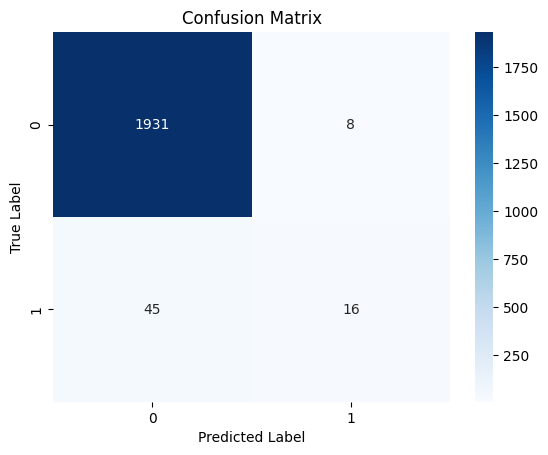

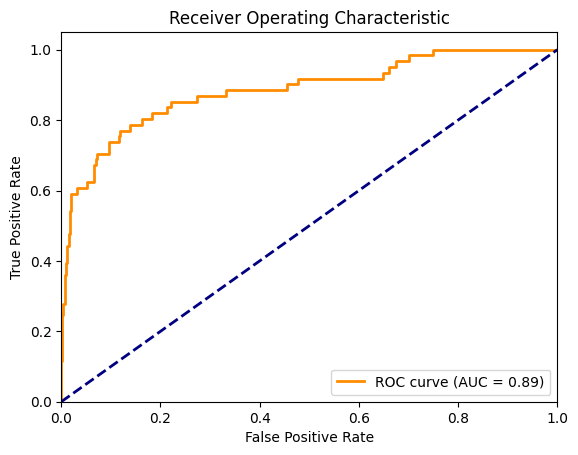

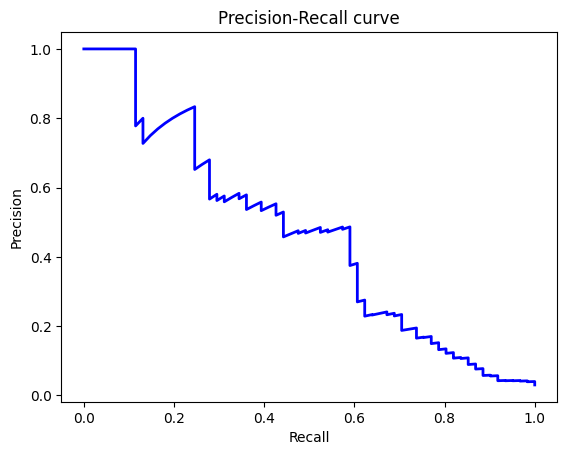

In [11]:
# Print the best parameters and best score
print("Best parameters found: ", grid_result)

# Make predictions on the test set
y_pred = grid_result.predict(X_test)
y_pred_proba = grid_result.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()